In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

In [2]:
# Load Dataset
file_path = "/content/us_retail_sales.xlsx"
df = pd.read_excel(file_path, sheet_name='us_retail_sales')
df

FileNotFoundError: [Errno 2] No such file or directory: '/content/us_retail_sales.xlsx'

In [ ]:
# Data Preprocessing
df['sales_month'] = pd.to_datetime(df['sales_month'])  # Convert to datetime
filtered_df = df[df['estimate_type'] == 'adjusted']  # Use seasonally adjusted sales
filtered_df = filtered_df[df['kind_of_business'] == 'Retail and food services sales, total']
filtered_df = filtered_df[['sales_month', 'sales']].dropna()
filtered_df.set_index('sales_month', inplace=True)
filtered_df = filtered_df.sort_index()


<ipython-input-46-8c9f8d7d3327>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[df['kind_of_business'] == 'Retail and food services sales, total']


In [ ]:
# Check for Null and Duplicate Values
df.isnull().sum()

,0
naics_code,5502
kind_of_business,0
sales_month,0
sales,986
estimate_type,0


In [ ]:
# Handle Missing Values
df.drop(columns=['naics_code'], inplace=True)  # Drop unnecessary column
df['sales'] = df['sales'].interpolate(method='linear')  # Fill missing sales values

In [ ]:
# Again Check for Null and Duplicate Values
df.isnull().sum()

,0
kind_of_business,0
sales_month,0
sales,0
estimate_type,0


In [ ]:
print("Duplicate Rows:", df.duplicated().sum())

Duplicate Rows: 0


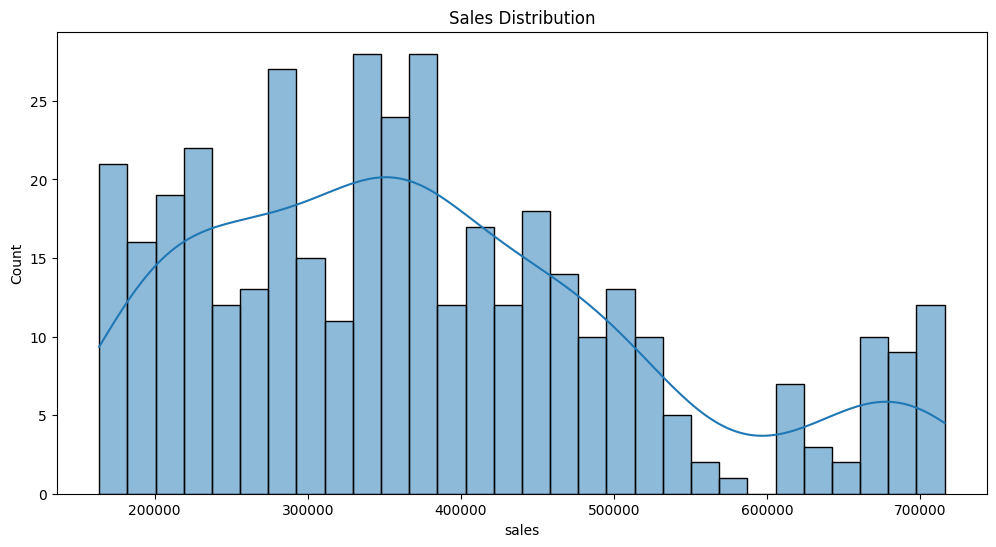

In [ ]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,6))
sns.histplot(filtered_df['sales'], bins=30, kde=True)
plt.title("Sales Distribution")
plt.show()


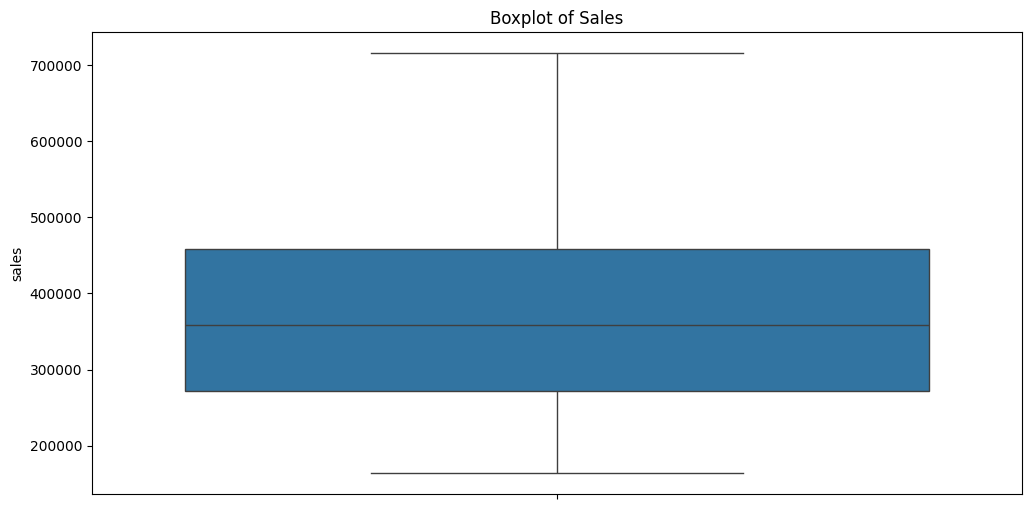

In [ ]:
plt.figure(figsize=(12,6))
sns.boxplot(y=filtered_df['sales'])
plt.title("Boxplot of Sales")
plt.show()


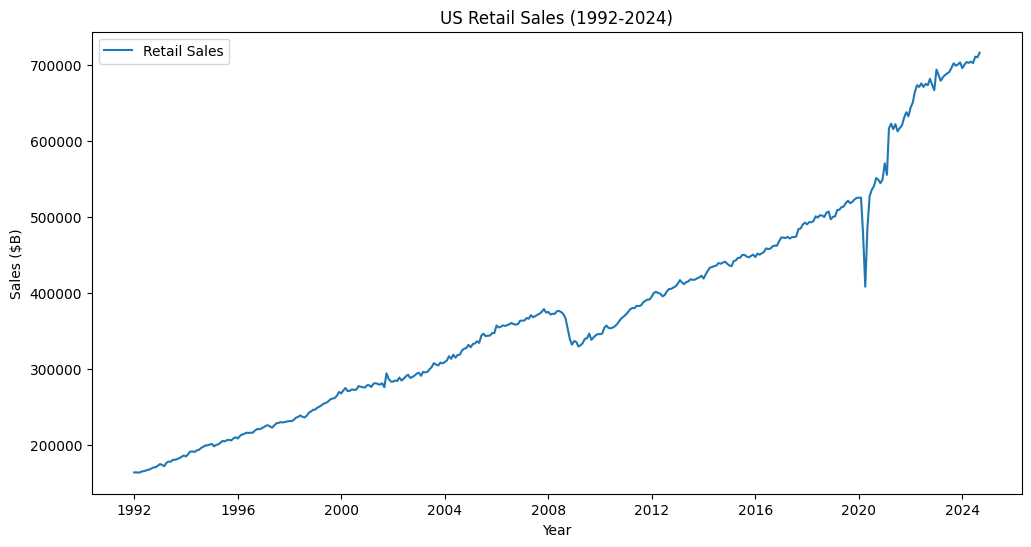

In [ ]:
# Data Visualization
plt.figure(figsize=(12,6))
sns.lineplot(data=filtered_df, x=filtered_df.index, y='sales', label='Retail Sales')
plt.title("US Retail Sales (1992-2024)")
plt.xlabel("Year")
plt.ylabel("Sales ($B)")
plt.legend()
plt.show()

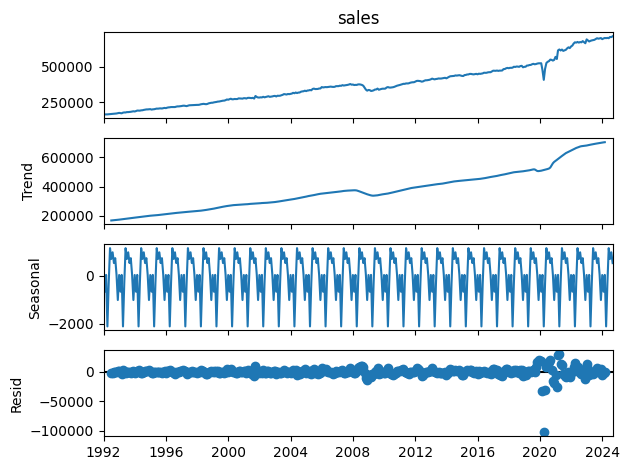

In [ ]:
# Check for Seasonality
decomposition = seasonal_decompose(filtered_df['sales'], model='additive', period=12)
decomposition.plot()
plt.show()


In [ ]:
# Apply SARIMA Model (since sales show seasonality)
sarima_model = SARIMAX(filtered_df['sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# Forecast Next 12 Months
forecast_sarima = sarima_fit.forecast(steps=12)
forecast_dates = pd.date_range(start=filtered_df.index[-1], periods=13, freq='M')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Predicted_Sales': forecast_sarima})
print(forecast_df)

                 Date  Predicted_Sales
2024-10-01 2024-10-31    717872.835845
2024-11-01 2024-11-30    718277.092192
2024-12-01 2024-12-31    718635.815471
2025-01-01 2025-01-31    721913.269405
2025-02-01 2025-02-28    722997.651603
2025-03-01 2025-03-31    726198.794591
2025-04-01 2025-04-30    723999.699760
2025-05-01 2025-05-31    729023.988662
2025-06-01 2025-06-30    732269.008872
2025-07-01 2025-07-31    734930.532485
2025-08-01 2025-08-31    736587.712411
2025-09-01 2025-09-30    739491.641958


<ipython-input-56-7ce13bb2f5cc>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_dates = pd.date_range(start=filtered_df.index[-1], periods=13, freq='M')[1:]


In [ ]:
# Evaluate Forecasting Model
y_true = filtered_df['sales'][-12:]  # Last 12 months actual sales
y_pred_sarima = forecast_sarima[:12]
print("MAE (SARIMA):", mean_absolute_error(y_true, y_pred_sarima))


MAE (SARIMA): 22761.336937802873


In [ ]:
forecast_df

,Date,Predicted_Sales
2024-10-01,2024-10-31,717872.835845
2024-11-01,2024-11-30,718277.092192
2024-12-01,2024-12-31,718635.815471
2025-01-01,2025-01-31,721913.269405
2025-02-01,2025-02-28,722997.651603
2025-03-01,2025-03-31,726198.794591
2025-04-01,2025-04-30,723999.699760
2025-05-01,2025-05-31,729023.988662
2025-06-01,2025-06-30,732269.008872
2025-07-01,2025-07-31,734930.532485


In [ ]:
df

,kind_of_business,sales_month,sales,estimate_type
0,Warehouse clubs and superstores,1992-01-01,2579.0,not adjusted
1,Retail sales and food services excl motor vehi...,1992-01-01,117814.0,adjusted
2,Retail sales and food services excl gasoline s...,1992-01-01,151292.0,adjusted
3,Retail sales and food services excl motor vehi...,1992-01-01,130617.0,adjusted
4,"Retail and food services sales, total",1992-01-01,164095.0,adjusted
...,...,...,...,...
40474,Men's clothing stores,2024-09-01,9621.0,not adjusted
40475,Clothing stores,2024-09-01,16569.0,not adjusted
40476,Clothing and clothing access. stores,2024-09-01,23142.0,not adjusted
40477,Limited service eating places,2024-09-01,41681.0,not adjusted


In [ ]:
df.rename(columns=lambda x: x.strip(), inplace=True)
forecast_df.rename(columns=lambda x: x.strip(), inplace=True)


In [ ]:
# Save for Power BI
df.to_csv("cleaned_sales_data.csv", index=False)


In [ ]:
# Save for Power BI
forecast_df.to_csv("forecast_data.csv", index=False)

In [ ]:
df2= pd.read_csv("/content/cleaned_sales_data.csv")

In [ ]:
df2

,kind_of_business,sales_month,sales,estimate_type
0,Warehouse clubs and superstores,1992-01-01,2579.0,not adjusted
1,Retail sales and food services excl motor vehi...,1992-01-01,117814.0,adjusted
2,Retail sales and food services excl gasoline s...,1992-01-01,151292.0,adjusted
3,Retail sales and food services excl motor vehi...,1992-01-01,130617.0,adjusted
4,"Retail and food services sales, total",1992-01-01,164095.0,adjusted
...,...,...,...,...
40474,Men's clothing stores,2024-09-01,9621.0,not adjusted
40475,Clothing stores,2024-09-01,16569.0,not adjusted
40476,Clothing and clothing access. stores,2024-09-01,23142.0,not adjusted
40477,Limited service eating places,2024-09-01,41681.0,not adjusted
